##### bns-remnant.ipynb

### *remnant matter contour plot from Kruger+Foucart 2020 fit to BNS merger simulations compared against estimated compact binary merger parameters*

this notebook plots contours of constant remnant mass (as a fraction of the lighter neutron star mass) as a function of black hole spin in binary neutron star mergers according to the empirical formula from Kruger+Foucart 2020, based on a suite of binary neutron star merger simulations, and overlays the estimated masses for a given candidate compact binary merger event

##### philippe landry (pgjlandry@gmail.com) 05/2024

In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import requests as rq
import json
import h5py
from src.utils import *
import src.kf20 as kf20
from src.plot import *

plt.rcParams["text.usetex"] = False
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# user input

F_threshold = 0.1

RNS = 12. # simulation values of the compactness range from 0.135 to 0.219

q_range = (0.775,1.) # simulation values of the mass ratio range from 0.775 to 1.
C_range = (0.135, 0.219) # simulation values of the compactness range from 0.135 to 0.219

m2_range = ((1e5*c**2*RNS)/(G*Msol))*np.array(C_range) 
m1_range = (m2_range[0]/q_range[1],m2_range[1]/q_range[0])

mNSgrid = (0.5,2.5)

In [3]:
# get all gwosc bns events

GWOSC_PATH_WEB = 'https://gwosc.org/eventapi/json/allevents/'
GWOSC_PATH_LOCAL = 'etc/gwosc_table.json'

if not os.path.isfile(GWOSC_PATH_LOCAL):

    gwosc_web = rq.get(GWOSC_PATH_WEB,allow_redirects=True)
    with open(GWOSC_PATH_LOCAL,'wb') as outfile: outfile.write(gwosc_web.content)

with open(GWOSC_PATH_LOCAL) as infile: gwosc_table = json.load(infile)

SNR_THRESH = 10.
NS_MMAX = 2.5
ns_events, versions = {}, {}

for event in gwosc_table['events'].keys():
    
    snr = gwosc_table['events'][event]['network_matched_filter_snr']
    snr_err = gwosc_table['events'][event]['network_matched_filter_snr_upper']
    if snr is None: print('warning: field "network_matched_filter_snr" for {0} is empty!'.format(event)); continue
    elif snr_err is None: snr_err = 0.
    snr_ub = snr + snr_err
    
    m1 = gwosc_table['events'][event]['mass_1_source']
    m1_err = gwosc_table['events'][event]['mass_1_source_lower']
    if m1 is None: print('warning: field "mass_1_source" for {0} is empty!'.format(event)); continue
    elif m1_err is None: m1_err = 0.
    m1_lb = m1 + m1_err

    if m1_lb <= NS_MMAX and snr_ub >= SNR_THRESH:

        ns_events[event] = {}
        ns_events[event]['m1'] = gwosc_table['events'][event]['mass_1_source']
        ns_events[event]['m2'] = gwosc_table['events'][event]['mass_2_source']
        ns_events[event]['snr'] = gwosc_table['events'][event]['network_matched_filter_snr']
        ns_events[event]['name'] = gwosc_table['events'][event]['commonName']
        ns_events[event]['url'] = gwosc_table['events'][event]['jsonurl']

        versions[ns_events[event]['name']] = 1
        if int(event[-1]) > versions[ns_events[event]['name']]: versions[ns_events[event]['name']] = int(event[-1])

ns_events_keys = [event.split('-')[0]+'-v{0}'.format(versions[ns_events[event]['name']]) for event in ns_events.keys() if event[-1] == str(versions[ns_events[event]['name']])]
print(ns_events_keys)

['GW230529_181500-v1', 'GW190425_081805-v3', 'GW170817-v3']


In [19]:
# get pe samples for bns events

pe_metadata, pe_samples = {}, {}

for event in ns_events_keys:

    print(event)
    
    GWOSC_PATH_WEB = ns_events[event]['url']
    GWOSC_PATH_LOCAL = 'etc/gwosc_page.json'
    
    gwosc_web = rq.get(GWOSC_PATH_WEB,allow_redirects=True)
    with open(GWOSC_PATH_LOCAL,'wb') as outfile: outfile.write(gwosc_web.content)
    
    with open(GWOSC_PATH_LOCAL) as infile: gwosc_page = json.load(infile)
    os.remove(GWOSC_PATH_LOCAL)

    pe_key = [key for key in gwosc_page['events'][event]['parameters'].keys() if 'pe_combined' in key]
    if pe_key == [] and event != 'GW170817-v3': ns_events_keys.remove(event); continue
    elif event == 'GW170817-v3': pe_key = 'gwtc1_pe_GW170817'
    else: pe_key = pe_key[-1]
    
    wf_key = gwosc_page['events'][event]['parameters'][pe_key]['waveform_family']
    if wf_key == 'TDB:Mixed': wf_key = 'Combined_PHM_highSpin'
    pe_url = gwosc_page['events'][event]['parameters'][pe_key]['data_url']

    pe_metadata[event] = {}
    pe_metadata[event]['waveform'] = wf_key
    pe_metadata[event]['url'] = pe_url

    PE_PATH_WEB = pe_url
    PE_PATH_LOCAL = 'etc/{0}.h5'.format(event)

    if not os.path.isfile(PE_PATH_LOCAL):
    
        pe_web = rq.get(PE_PATH_WEB,allow_redirects=True)
        with open(PE_PATH_LOCAL,'wb') as outfile: outfile.write(pe_web.content)
        
    pe_data = h5py.File(PE_PATH_LOCAL, 'r')

    pe_samples[event] = {}
    
    if event != 'GW170817-v3':
        pe_samples[event]['m1'] = np.array(pe_data[wf_key]['posterior_samples'])['mass_1_source']
        pe_samples[event]['m2'] = np.array(pe_data[wf_key]['posterior_samples'])['mass_2_source']
        pe_samples[event]['chi1z'] = np.array(pe_data[wf_key]['posterior_samples'])['spin_1z']
    
    else:
        pe_samples[event]['m1'] = np.array(pe_data[wf_key])['m1_detector_frame_Msun']/(1.+0.0099)
        pe_samples[event]['m2'] = np.array(pe_data[wf_key])['m2_detector_frame_Msun']/(1.+0.0099)
        pe_samples[event]['chi1z'] = np.array(pe_data[wf_key])['spin1']

print(pe_samples.keys())

GW230529_181500-v1
GW190425_081805-v3
GW170817-v3
dict_keys(['GW230529_181500-v1', 'GW190425_081805-v3', 'GW170817-v3'])


In [20]:
# get gwtc-3 bns mass distribution

POP_PATH_WEB = 'https://zenodo.org/records/5655785/files/GWTC-3-population-data.tar.gz?download=1'
POP_PATH_LOCAL = 'etc/gwtc3_population_data.tar.gz'
PDB_PATH_LOCAL = 'etc/GWTC-3-population-data/analyses/PowerlawDipBreak/O1O2O3all_mass_h_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'

if not os.path.isfile(PDB_PATH_LOCAL):

    if not os.path.isfile(POP_PATH_LOCAL):
    
        pop_web = rq.get(POP_PATH_WEB,allow_redirects=True)
        with open(POP_PATH_LOCAL,'wb') as outfile: outfile.write(pop_web.content)
    
    with tarfile.open(POP_PATH_LOCAL) as infile: infile.extractall('etc/')

with open(PDB_PATH_LOCAL) as infile: pop_data = h5py.File(PDB_PATH_LOCAL,'r')

pdb_mgrid = np.array(pop_data['lines']['mass'])
pdb_rate = np.array(pop_data['ppd']).reshape(-1)
pdb_x,pdb_y = np.meshgrid(pdb_mgrid,pdb_mgrid)
pdb_x = pdb_x.reshape(-1)
pdb_y = pdb_y.reshape(-1)

num_pdb = 100000
pdb_idxs = np.random.choice(len(pdb_rate),num_pdb,True,pdb_rate/np.sum(pdb_rate))
pdb_m1s = pdb_x[pdb_idxs]
pdb_m2s = pdb_y[pdb_idxs]

idxs1 = np.where(pdb_m1s <= mNSgrid[1])
idxs2 = np.where(pdb_m2s <= mNSgrid[1])
pdb_idxs = list(set(list(idxs1[0])).intersection(list(idxs2[0])))
pdb_m1s = pdb_m1s[pdb_idxs]
pdb_m2s = pdb_m2s[pdb_idxs]

/tmp/ipykernel_2281229/4207496195.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  COLORS = cm.get_cmap('PuBuGn_r',len(ns_events_keys)+3)
/home/philippe.landry/em-dash/src/kf20.py:12: RuntimeWarning: invalid value encountered in power
  return np.where(F**delta > 5e-4, F**delta, 5e-4)
/tmp/ipykernel_2281229/4207496195.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pe_samples[event]['m2'][idxs],pe_samples[event]['m1'][idxs],marker='.',s=2,c=COLORS(i),alpha=0.2,zorder=1)
/cvmfs/software.igwn.org/conda/envs/igwn-py39/

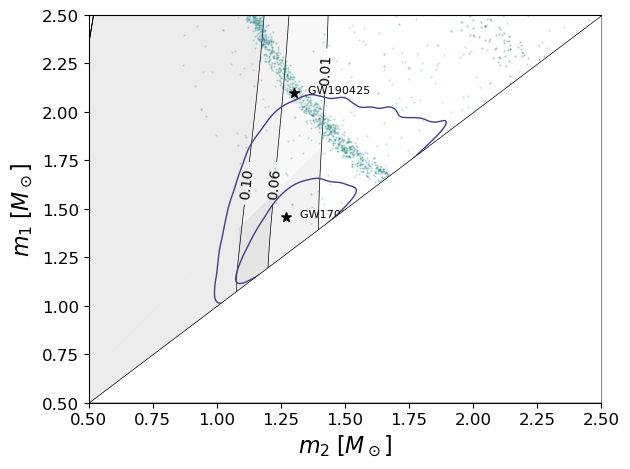

In [21]:
# make contour plot

NUM_SCATTER = 1000
COLORS = cm.get_cmap('PuBuGn_r',len(ns_events_keys)+3)

plt.figure()

bns_remnant_mass_contour_plot(mNSgrid,RNS,F_threshold,m1range=m1_range,m2range=m2_range,qrange=q_range,model=kf20.F_remnant)

for i,event in enumerate(pe_samples.keys()):

    plt.scatter(ns_events[event]['m2'],ns_events[event]['m1'],marker='*',s=50,c='k',zorder=2)
    plt.annotate('    '+ns_events[event]['name'].split('_')[0],(ns_events[event]['m2'],ns_events[event]['m1']),fontsize=8)

    idxs = np.random.choice(range(len(pe_samples[event]['m1'])),NUM_SCATTER)
    plt.scatter(pe_samples[event]['m2'][idxs],pe_samples[event]['m1'][idxs],marker='.',s=2,c=COLORS(i),alpha=0.2,zorder=1)

sns.kdeplot(x=pdb_m2s,y=pdb_m1s,levels=[0.1,0.5],color='darkslateblue',linewidths=1)

plt.xlabel(r'$m_2\;[M_\odot]$',fontsize=16)
plt.ylabel(r'$m_1\;[M_\odot]$',fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# make interactive